参考
https://qiita.com/Lukas04/items/885f5371f82b7ad7a635

[実施内容]
2019年4月～2024年3月のデータを取得し，2024年4月の30日間の気温を予測する．

In [3]:
!nvidia-smi

Fri May 31 15:18:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   53C    P8              6W /   30W |     779MiB /   4096MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch
print(torch.cuda.is_available())

print(torch.version.cuda)
print(torch.cuda.get_arch_list())
print(torch.cuda.get_device_capability())

True
11.7
['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'compute_37']
(8, 6)


In [5]:
import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

c:\Users\hmina\OneDrive\デスクトップ\tarantula\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# beautifulsoup
import requests
from bs4 import BeautifulSoup

# selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from time import sleep

In [ ]:
# 東京都練馬区を選択
url = 'https://www.data.jma.go.jp/obd/stats/etrn/index.php?prec_no=44&block_no=1002&year=&month=&day=&view='
# セットアップ
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)
driver.get(url)

In [ ]:
# 取得したデータの変換: 方角を整数値に変換、北を0°として360°で表記
def kanji_direction_to_degree(kanji_direction):
    direction = None

    match   kanji_direction:
        case '北北東':
            direction = 23
        case '東北東':
            direction = 68           
        case '東南東':
            direction = 113
        case '南南東':
            direction = 158
        case '南南西':
            direction = 203
        case '西南西':
            direction = 248
        case '西北西':
            direction = 293
        case '北北西':
            direction = 335
        case '北東':
            direction = 45
        case '南東':
            direction = 135
        case '南西':
            direction = 225
        case '北西':
            direction = 315
        case '北':
            direction = 0
        case '東':
            direction = 90
        case '南':
            direction = 180
        case '西':
            direction = 270
        case _:  #判別不能なデータがきたとき
            direction = None
    return direction

# 取得したデータの変換:  float型に変換する。変換できない文字は0.0で代用。
# ※観測データのうち、データが無い（または変換不能なデータが当てはめられている）のは
#  測定結果が0とか測定限界以下だったんだな、って思って差し支えないデータはこっちを使う
#  例: 降雨量、降雪量

def str2float_z(str):
    try:
        return float(str)
    except:
        return 0.0

# 取得したデータの変換: float型に変換する。変換できない場合はNoneを返す。
# ※観測データのうち、データが無い（または変換不能なデータが当てはめられている）のは
#  0として考えると差し支えがあるデータの場合(つまり0と言うデータにも意味がある場合)は
# こっちを使う。
# #  例: 気温、気圧、湿度等
def str2float_n(str):
    try:
        return float(str)
    except:
        return None

In [ ]:
# csvファイルのHeader
header = ['year', 'month', 'day', 'ave_rainfall', 'ave_temperature', 'max_temperature', 'min_temperature', 'ave_wind_speed', 'max_wind_speed', 'max_wind_direction', 'sunshine_hours']

df = []
res = requests.get(url)
# 2024年がa[1], 2023年がa[2], ..., 2019年がa[6]
wait = WebDriverWait(driver, 30)

for year_idx in range(6, 0, -1):
    year_x_path = f'//*[@id="main"]/table[4]/tbody/tr/td[2]/div/table/tbody/tr[2]/td[1]/table/tbody/tr/td[1]/a[{year_idx}]'
    wait.until(EC.presence_of_element_located((By.XPATH, year_x_path))) # ページ遷移を待つのがこれ
    year_button = driver.find_element(By.XPATH, year_x_path)
    year = int(year_button.text[:-1])
    year_button.click()
    sleep(2)
    
    for month_idx in range(12):
        if year_idx == 1 and month_idx == 4:
            break
        month = month_idx + 1
        if month_idx == 0:
            month_x_path = f'//*[@id="main"]/table[4]/tbody/tr/td[2]/div/table/tbody/tr[2]/td[3]/table/tbody/tr/td/a[{month_idx + 1}]'
        else:
            month_x_path = f'//*[@id="main"]/table[4]/tbody/tr/td[2]/div/table/tbody/tr[2]/td[3]/table/tbody/tr/td/a[{month_idx}]'
        wait.until(EC.presence_of_element_located((By.XPATH, month_x_path)))

        month_button = driver.find_element(By.XPATH, month_x_path)
        month_button.click()
        sleep(2)
        
        # 「日ごとの値」をクリック
        day_x_path = f'//*[@id="main"]/table[4]/tbody/tr/td[3]/div/table/tbody/tr[7]/td[1]/table/tbody/tr[1]/td[2]/a'
        wait.until(EC.presence_of_element_located((By.XPATH, day_x_path)))

        each_day_button = driver.find_element(By.XPATH, day_x_path)
        each_day_button.click()
        sleep(5)
        
        current_url = driver.current_url
        
        r = requests.get(current_url)
        c = r.content
        soup = BeautifulSoup(c, 'html.parser') # このページのタグを一斉に取得
        
        # beautifulsoupで表形式データを取得
        rows = soup.findAll('tr', class_= 'mtx')
        rows = rows[3:]    
        
        for row in rows:
            # 項目毎に分割
            weather_data = [year, month]
            items = row.findAll('td')
            day = int(items[0].text)
            weather_data.append(day)
            for idx in [1,4,5,6,9,10,11,15]:
                if idx == 11:
                    each_data = kanji_direction_to_degree(items[idx].text) # TODO: def kanji_direction_to_degreeを作成
                elif idx == 15:
                    each_data = str2float_z(items[idx].text) # 日照時間
                else:
                    each_data = str2float_n(items[idx].text) # それ以外
                weather_data.append(each_data)        
            df.append(weather_data)
            print(df)
    
        driver.back()
        sleep(1)

# ブラウザを閉じる
driver.quit()
print("finish")

In [93]:
# appendしたlistをcsv化
df = pd.DataFrame(df, columns=header)
# CSVファイルに保存（practiceの外に置いてimport）
df.to_csv('weather_data_Nerima_5y.csv', index=False)

NameError: name 'header' is not defined

In [129]:
# csvの中身を確認
df = pd.read_csv('weather_data_Nerima_5y.csv')
df.head()

,year,month,day,ave_rainfall,ave_temperature,max_temperature,min_temperature,ave_wind_speed,max_wind_speed,max_wind_direction,sunshine_hours
0,2019,1,1,0.0,4.5,11.0,-1.4,0.9,3.4,335,8.8
1,2019,1,2,0.0,5.6,11.0,1.1,2.4,5.0,0,8.6
2,2019,1,3,0.0,4.1,10.9,-2.4,2.3,6.4,0,9.0
3,2019,1,4,0.0,3.8,10.5,-2.1,0.7,2.6,0,9.1
4,2019,1,5,0.0,6.5,15.3,-1.3,1.7,5.0,335,9.1


In [130]:
print(df.isnull().sum())
df[df.isna().any(axis=1)]

year                   0
month                  0
day                    0
ave_rainfall           4
ave_temperature        5
max_temperature       12
min_temperature       10
ave_wind_speed        11
max_wind_speed        11
max_wind_direction     0
sunshine_hours         0
dtype: int64


,year,month,day,ave_rainfall,ave_temperature,max_temperature,min_temperature,ave_wind_speed,max_wind_speed,max_wind_direction,sunshine_hours
160,2019,6,10,70.5,16.2,NaN,15.1,2.9,4.9,0,0.0
206,2019,7,26,1.5,29.1,NaN,NaN,NaN,NaN,203,0.0
576,2020,7,30,0.5,23.5,NaN,NaN,NaN,NaN,23,0.0
725,2020,12,26,0.0,5.6,11.7,-0.3,NaN,NaN,0,8.8
765,2021,2,4,NaN,NaN,NaN,NaN,NaN,NaN,315,0.0
777,2021,2,16,NaN,NaN,NaN,NaN,NaN,NaN,248,0.0
958,2021,8,16,1.0,20.9,NaN,19.2,1.1,2.6,335,0.0
1017,2021,10,14,0.0,19.0,NaN,NaN,NaN,NaN,23,7.0
1052,2021,11,18,NaN,NaN,NaN,NaN,NaN,NaN,335,2.1
1073,2021,12,9,NaN,NaN,NaN,NaN,NaN,NaN,23,7.0


In [131]:
# 欠損値(上記で置換したNanや0)があるか確かめる→ある場合，線形補間（前後の値の中間値）
df = df.interpolate(method='linear')
df.isnull().sum()

year                  0
month                 0
day                   0
ave_rainfall          0
ave_temperature       0
max_temperature       0
min_temperature       0
ave_wind_speed        0
max_wind_speed        0
max_wind_direction    0
sunshine_hours        0
dtype: int64

year                 -0.074499
month                 0.342985
day                   0.019099
ave_rainfall          0.069566
ave_temperature       1.000000
max_temperature       0.977965
min_temperature       0.979232
ave_wind_speed       -0.301742
max_wind_speed       -0.303372
max_wind_direction   -0.002613
sunshine_hours       -0.028798
Name: ave_temperature, dtype: float64


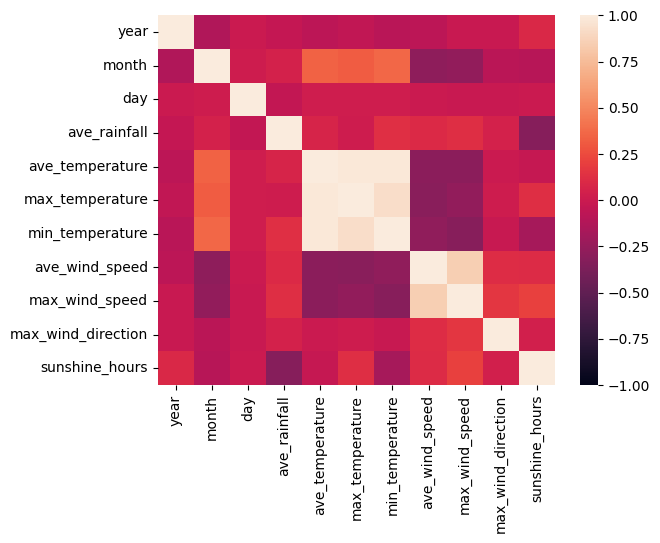

In [132]:
# 平均気温との他の変数との相関関係，heatmap
import seaborn as sns

# 相関関係
corr_matrix = df.corr()
print(corr_matrix["ave_temperature"])

# ヒートマップ
sns.heatmap(corr_matrix, vmin=-1, vmax=1)
plt.show()

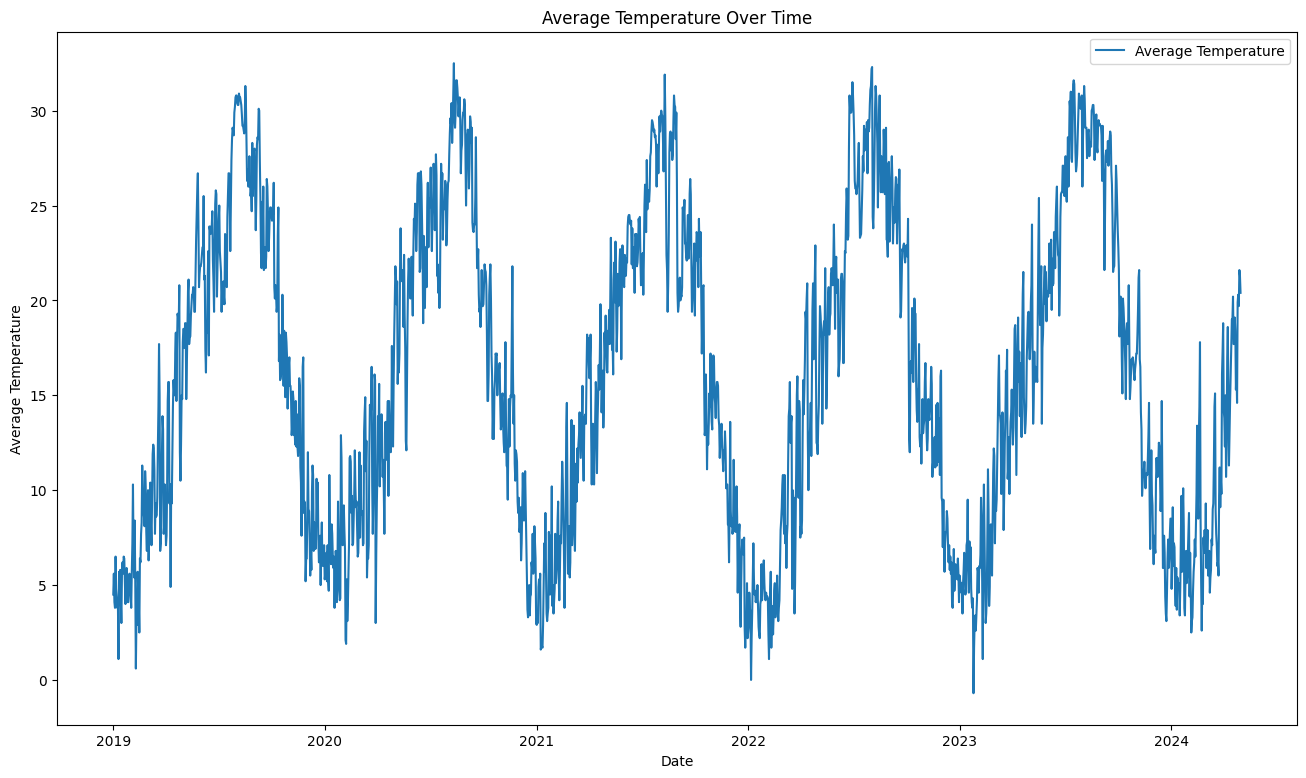

In [133]:
# 平均気温に関する時系列の折れ線グラフ
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
plt.figure(figsize=(16, 9))
plt.plot(df['date'], df['ave_temperature'], label='Average Temperature')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.title('Average Temperature Over Time')
plt.legend()
plt.show()

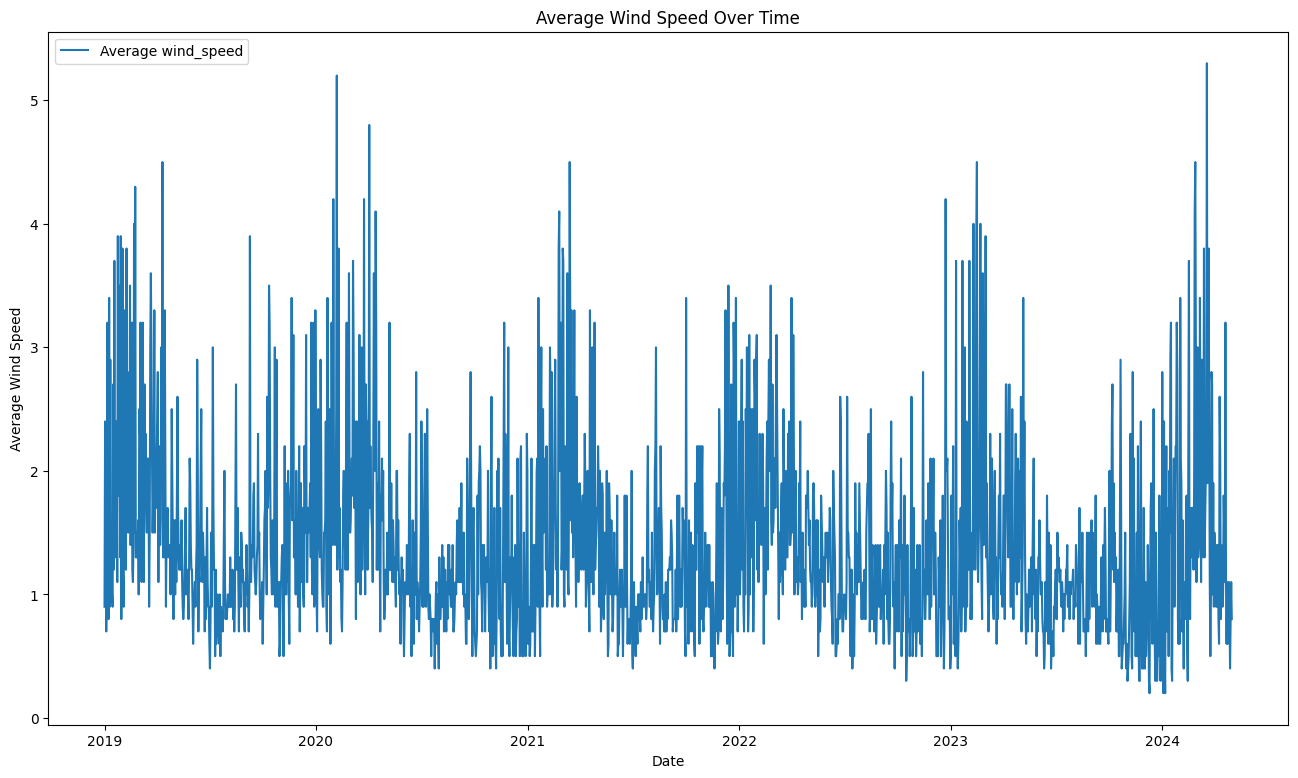

In [12]:
# 平均風速に関する時系列の折れ線グラフ
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
plt.figure(figsize=(16, 9))
plt.plot(df['date'], df['ave_wind_speed'], label='Average wind_speed')
plt.xlabel('Date')
plt.ylabel('Average Wind Speed')
plt.title('Average Wind Speed Over Time')
plt.legend()
plt.show()

In [134]:
# すべての取得データを標準化
from sklearn.preprocessing import StandardScaler

# 標準化のクラスを定義
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(df.drop(columns=['date'])), columns=df.columns.drop('date'))

In [135]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# 前日のデータを用いて翌日のデータを予測する
# 発展：平均気温を入力に使いたい，入力を7個にして出力を7個にしてほしい，など（今のだと単に長期記憶に強いテーブルデータ予測になっている）
X = df_std.drop("ave_temperature", axis=1) # Xの最後の1つを削る＆Xに平均気温を入れてOK
y = df_std["ave_temperature"] # yの先頭を1個削る

X_train = X[:-30] # 2024年3月までのデータ
y_train = y[:-30]
X_test = X[-30:]
y_test = y[-30:]

# 検証データを取る
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print("train size: {}, valid size: {}, test size: {} ".format(len(y_train), len(y_valid), len(y_test)))

train size: 1725, valid size: 192, test size: 30 


In [136]:
# テンソルデータの準備 # 質問（やっていること，効果）
# Pytorchの性質上，テンソル型で入力するから（配列などは△）
def create_dataloader(X, y, batch_size=64):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_dataloader(X_train, y_train)
valid_loader = create_dataloader(X_valid, y_valid)
test_loader = create_dataloader(X_test, y_test, batch_size=1) # 1個ずつ予測，時系列データでwindow sizeで出力することが多い（今回は1, 7日間まとめてだと7），目的による

# RNNモデルの定義
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1): # output_sizeがwindow sizeになってくる(7にすると誤差の計算方法も変わってくる＝ベクトルーベクトル)
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size) # 回帰だから線形回帰，分類だったらsigmoidやsoftmax
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# LSTMモデルの定義
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

DNNのコードは，コードを理解できていればOK（ハイパラ改善したい，層増やしたいなどができればOK）

In [137]:
device = 'cuda'

# 訓練関数の修正
def train(model, train_loader, valid_loader, criterion, optimizer, n_epochs=10):
    model.to(device)
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.unsqueeze(1).to(device) # 次元を変えている，1次元追加する(2,3)→(2,1,3)など,入力の形態を揃えている
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch = X_batch.unsqueeze(1).to(device)
                y_batch = y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                valid_loss += loss.item()

        print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Valid Loss: {valid_loss/len(valid_loader)}')

In [149]:
print(X_train.shape)
print(y_train.shape)

(1725, 10)
(1725, 1)


In [140]:
# RNNの訓練
input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
num_layers = 2
n_epochs = 10
lr = 0.1

net_rnn = RNN(input_size, hidden_size, output_size, num_layers).to(device)
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=lr)
criterion = nn.MSELoss()

train(net_rnn, train_loader, valid_loader, criterion, optimizer, n_epochs) # 回帰の場合はMSELoss

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import torch

# y用のスケーラーを別に定義する（fitしておく必要があります）
y_scaler = StandardScaler()

# y_trainを用いてfit
y_train = y_train.values.reshape(-1, 1)  # reshape to 2D if needed
y_scaler.fit(y_train)

# RNNの精度評価
net_rnn.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.unsqueeze(1).to(device)
        output = net_rnn(X_batch)
        y_pred.append(output.item())

y_pred = np.array(y_pred).reshape(-1, 1)  # y_predを2次元に変換
y_test = y_test.values.reshape(-1, 1)  # y_testを2次元に変換

# 逆変換（標準化からもとに戻している）
y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# 回帰モデルの評価指標
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Epoch 1, Train Loss: 0.9671995140336178, Valid Loss: 0.11353133122126262
Epoch 2, Train Loss: 0.07605766160068689, Valid Loss: 0.028951935470104218
Epoch 3, Train Loss: 0.02996873469264419, Valid Loss: 0.017400685076912243
Epoch 4, Train Loss: 0.017415072975887194, Valid Loss: 0.021558343743284542
Epoch 5, Train Loss: 0.01328069868463057, Valid Loss: 0.014392517507076263
Epoch 6, Train Loss: 0.012137295954205372, Valid Loss: 0.013607311993837357
Epoch 7, Train Loss: 0.011024000157636625, Valid Loss: 0.012941348676880201
Epoch 8, Train Loss: 0.00988655061357551, Valid Loss: 0.011203509755432606
Epoch 9, Train Loss: 0.013755251463778593, Valid Loss: 0.018087855850656826
Epoch 10, Train Loss: 0.011286257610966762, Valid Loss: 0.015716310900946457
Root Mean Squared Error (RMSE): 0.5856575737551378


In [142]:
# RNNの訓練
input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
num_layers = 2
n_epochs = 30
lr = 0.1

net_rnn = RNN(input_size, hidden_size, output_size, num_layers).to(device)
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=lr)
criterion = nn.MSELoss()

train(net_rnn, train_loader, valid_loader, criterion, optimizer, n_epochs) # 回帰の場合はMSELoss

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import torch

# y用のスケーラーを別に定義する（fitしておく必要があります）
y_scaler = StandardScaler()

# y_trainを用いてfit
y_train = y_train.values.reshape(-1, 1)  # reshape to 2D if needed
y_scaler.fit(y_train)

# RNNの精度評価
net_rnn.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.unsqueeze(1).to(device)
        output = net_rnn(X_batch)
        y_pred.append(output.item())

y_pred = np.array(y_pred).reshape(-1, 1)  # y_predを2次元に変換
y_test = y_test.values.reshape(-1, 1)  # y_testを2次元に変換

# 逆変換
y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# 回帰モデルの評価指標
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1, Train Loss: 1.4803253649561494, Valid Loss: 0.40713415543238324
Epoch 2, Train Loss: 0.21140223796720858, Valid Loss: 0.12093829363584518
Epoch 3, Train Loss: 0.11040571262990986, Valid Loss: 0.08330794423818588
Epoch 4, Train Loss: 0.0828861274101116, Valid Loss: 0.08411767333745956
Epoch 5, Train Loss: 0.05209033294684357, Valid Loss: 0.048826598872741066
Epoch 6, Train Loss: 0.036768827104458106, Valid Loss: 0.04707255711158117
Epoch 7, Train Loss: 0.029084071861924948, Valid Loss: 0.02780923868219058
Epoch 8, Train Loss: 0.01965750681443347, Valid Loss: 0.027247401575247448
Epoch 9, Train Loss: 0.019780478336744838, Valid Loss: 0.029984281087915104
Epoch 10, Train Loss: 0.019260617111016204, Valid Loss: 0.021003782128294308
Epoch 11, Train Loss: 0.026334299602442317, Valid Loss: 0.06340232988198598
Epoch 12, Train Loss: 0.039185238933121716, Valid Loss: 0.039790804187456764
Epoch 13, Train Loss: 0.028211951462758914, Valid Loss: 0.040964181845386825
Epoch 14, Train Loss: 0

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [108]:
# RNNの訓練
input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
num_layers = 2
n_epochs = 50
lr = 0.1

net_rnn = RNN(input_size, hidden_size, output_size, num_layers).to(device)
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=lr)
criterion = nn.MSELoss()

train(net_rnn, train_loader, valid_loader, criterion, optimizer, n_epochs) # 回帰の場合はMSELoss

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import torch

# y用のスケーラーを別に定義する（fitしておく必要があります）
y_scaler = StandardScaler()

# y_trainを用いてfit
y_train = y_train.reshape(-1, 1)  # reshape to 2D if needed
y_scaler.fit(y_train)

# RNNの精度評価
net_rnn.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.unsqueeze(1).to(device)
        output = net_rnn(X_batch)
        y_pred.append(output.item())

y_pred = np.array(y_pred).reshape(-1, 1)  # y_predを2次元に変換
y_test = y_test.values.reshape(-1, 1)  # y_testを2次元に変換

# 逆変換
y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# 回帰モデルの評価指標
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Epoch 1, Train Loss: 2.4086531243826212, Valid Loss: 0.6631962458292643
Epoch 2, Train Loss: 0.3509199799675691, Valid Loss: 0.4253855099280675
Epoch 3, Train Loss: 0.14222247977005809, Valid Loss: 0.05933246916780869
Epoch 4, Train Loss: 0.06310721565234034, Valid Loss: 0.05917855973045031
Epoch 5, Train Loss: 0.03494542327366377, Valid Loss: 0.018475404009222984
Epoch 6, Train Loss: 0.022200441331063445, Valid Loss: 0.0233621293057998
Epoch 7, Train Loss: 0.015620149426946514, Valid Loss: 0.014141957780035833
Epoch 8, Train Loss: 0.014590405172815448, Valid Loss: 0.02430848901470502
Epoch 9, Train Loss: 0.021605239004680987, Valid Loss: 0.01742045038069288
Epoch 10, Train Loss: 0.014710727343825917, Valid Loss: 0.012015979814653596
Epoch 11, Train Loss: 0.012800696060845726, Valid Loss: 0.02223703699807326
Epoch 12, Train Loss: 0.01902213099559671, Valid Loss: 0.011787241829248766
Epoch 13, Train Loss: 0.012598915466744649, Valid Loss: 0.012768379257371029
Epoch 14, Train Loss: 0.013

In [143]:
# Optunaによるハイパーパラメータチューニング(RNN)
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 10, 100)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 32, 128)

    model = RNN(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_loader = create_dataloader(X_train, y_train, batch_size)
    valid_loader = create_dataloader(X_valid, y_valid, batch_size)

    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

# Optunaのチューニング
study = optuna.create_study(direction='minimize') # optunaのライブラリ
study.optimize(objective, n_trials=50)
best_params_LSTM = study.best_params
print("Best params:", best_params_LSTM)

[I 2024-05-31 16:56:39,159] A new study created in memory with name: no-name-3c638bc6-9dbc-45ed-a95b-5069ffd02251
C:\temp\ipykernel_25872\505801955.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[W 2024-05-31 16:56:39,164] Trial 0 failed with parameters: {'hidden_size': 77, 'num_layers': 1, 'lr': 0.00037889597559793276, 'batch_size': 85} because of the following error: AttributeError("'numpy.ndarray' object has no attribute 'values'").
Traceback (most recent call last):
  File "c:\Users\hmina\OneDrive\デスクトップ\tarantula\env\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\temp\ipykernel_25872\505801955.py", line 12, in objective
    train_loader = create_dataloader(X_train, y_tra

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [145]:
# Best params: {'hidden_size': 99, 'num_layers': 1, 'lr': 0.0010715511851250084, 'batch_size': 58} # earlystoppingつかったら過学習防げそう
input_size = X_train.shape[1]
hidden_size = 99
output_size = 1
num_layers = 1
n_epochs = 50
lr = 0.0010715511851250084
batch_size = 58

net_rnn = RNN(input_size, hidden_size, output_size, num_layers).to(device)
optimizer = torch.optim.Adam(net_rnn.parameters(), lr=lr)
criterion = nn.MSELoss()

train(net_rnn, train_loader, valid_loader, criterion, optimizer, n_epochs) # 回帰の場合はMSELoss

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import torch

# y用のスケーラーを別に定義する（fitしておく必要があります）
y_scaler = StandardScaler()

# y_trainを用いてfit
y_train = y_train.reshape(-1, 1)  # reshape to 2D if needed
y_scaler.fit(y_train)

# RNNの精度評価
net_rnn.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.unsqueeze(1).to(device)
        output = net_rnn(X_batch)
        y_pred.append(output.item())

y_pred = np.array(y_pred).reshape(-1, 1)  # y_predを2次元に変換
y_test = y_test.reshape(-1, 1)  # y_testを2次元に変換

# 逆変換
y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# 回帰モデルの評価指標
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


Epoch 1, Train Loss: 0.5946515986212978, Valid Loss: 0.2615245133638382
Epoch 2, Train Loss: 0.12341893988626974, Valid Loss: 0.03102218235532443
Epoch 3, Train Loss: 0.012335621958805455, Valid Loss: 0.004086406202986836
Epoch 4, Train Loss: 0.004530356334591353, Valid Loss: 0.004415847361087799
Epoch 5, Train Loss: 0.004169278295227775, Valid Loss: 0.004118789142618577
Epoch 6, Train Loss: 0.004108468113743045, Valid Loss: 0.004196420777589083
Epoch 7, Train Loss: 0.004088259021820569, Valid Loss: 0.004027585654209058
Epoch 8, Train Loss: 0.004064184587655796, Valid Loss: 0.0039475103840231895
Epoch 9, Train Loss: 0.00403577782627609, Valid Loss: 0.004088885926951964
Epoch 10, Train Loss: 0.004007326016478517, Valid Loss: 0.004200888176759084
Epoch 11, Train Loss: 0.004021384925753982, Valid Loss: 0.00404728561018904
Epoch 12, Train Loss: 0.0040222246596520695, Valid Loss: 0.004080195057516296
Epoch 13, Train Loss: 0.004050964963863845, Valid Loss: 0.003951725860436757
Epoch 14, Trai

In [ ]:
# LSTMの訓練
input_size = X_train.shape[1]
hidden_size = 50
output_size = 1
num_layers = 2
n_epochs = 50
lr = 0.1

net_lstm = LSTM(input_size, hidden_size, output_size, num_layers).to(device)
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

train(net_lstm, train_loader, valid_loader, criterion, optimizer, n_epochs) # 回帰の場合はMSELoss

# y用のスケーラーを別に定義する（fitしておく必要があります）
y_scaler = StandardScaler()

# y_trainを用いてfit
y_train = y_train.reshape(-1, 1)  # reshape to 2D if needed
y_scaler.fit(y_train)

# LSTMの精度評価
net_lstm.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.unsqueeze(1).to(device)
        output = net_lstm(X_batch)
        y_pred.append(output.item())

y_pred = np.array(y_pred).reshape(-1, 1)  # y_predを2次元に変換
y_test = y_test.reshape(-1, 1)  # y_testを2次元に変換

# 逆変換
y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# 回帰モデルの評価指標
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1, Train Loss: 0.2100067662971991, Valid Loss: 0.040861046562592186
Epoch 2, Train Loss: 0.02126752195396909, Valid Loss: 0.009991179220378399
Epoch 3, Train Loss: 0.007404608341554801, Valid Loss: 0.006722131744027138
Epoch 4, Train Loss: 0.006083239007879187, Valid Loss: 0.008361243487646183
Epoch 5, Train Loss: 0.006235257894904526, Valid Loss: 0.006618164945393801
Epoch 6, Train Loss: 0.007619052435512896, Valid Loss: 0.009638494501511255
Epoch 7, Train Loss: 0.007533207915171429, Valid Loss: 0.008725383784621954
Epoch 8, Train Loss: 0.006454174355086353, Valid Loss: 0.010352735873311758
Epoch 9, Train Loss: 0.009875451145624672, Valid Loss: 0.00681195966899395
Epoch 10, Train Loss: 0.006337347923329583, Valid Loss: 0.007919172756373882
Epoch 11, Train Loss: 0.005272805242350808, Valid Loss: 0.005517531652003527
Epoch 12, Train Loss: 0.005583504042415707, Valid Loss: 0.00590302391598622
Epoch 13, Train Loss: 0.005389309677950762, Valid Loss: 0.00827275092403094
Epoch 14, Trai

In [104]:
# Optunaによるハイパーパラメータチューニング(LSTM)
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 10, 100)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 32, 128)

    model = LSTM(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_loader = create_dataloader(X_train, y_train, batch_size)
    valid_loader = create_dataloader(X_valid, y_valid, batch_size)

    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch = X_batch.unsqueeze(1).to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            valid_loss += loss.item()

    return valid_loss / len(valid_loader)

# Optunaのチューニング
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params_LSTM = study.best_params
print("Best params:", best_params_LSTM)

[I 2024-05-31 16:16:38,960] A new study created in memory with name: no-name-c0ee636c-3a59-49a9-90f5-6af173f3ea6f
C:\temp\ipykernel_25872\1789856084.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-05-31 16:16:39,945] Trial 0 finished with value: 0.004231947939842939 and parameters: {'hidden_size': 87, 'num_layers': 1, 'lr': 0.0017095514359061555, 'batch_size': 105}. Best is trial 0 with value: 0.004231947939842939.
[I 2024-05-31 16:16:40,733] Trial 1 finished with value: 0.9952765703201294 and parameters: {'hidden_size': 33, 'num_layers': 1, 'lr': 6.355532328606111e-05, 'batch_size': 113}. Best is trial 0 with value: 0.004231947939842939.
[I 2024-05-31 16:16:41,468] Trial 2 finished with value: 0.9138658046722412 and parameters: {'hidden_size': 30, 'num_layers': 1, 'lr

Best params: {'hidden_size': 80, 'num_layers': 2, 'lr': 0.0034992729563929946, 'batch_size': 95}


In [113]:
# Best params: {'hidden_size': 80, 'num_layers': 2, 'lr': 0.0034992729563929946, 'batch_size': 95}
# LSTMの訓練
input_size = X_train.shape[1]
hidden_size = 80
output_size = 1
num_layers = 2
n_epochs = 50
lr = 0.0034992729563929946
batch_size = 95

net_lstm = LSTM(input_size, hidden_size, output_size, num_layers).to(device)
optimizer = torch.optim.Adam(net_lstm.parameters(), lr=lr)
criterion = nn.MSELoss()

train(net_lstm, train_loader, valid_loader, criterion, optimizer, n_epochs) # 回帰の場合はMSELoss

# y用のスケーラーを別に定義する（fitしておく必要があります）
y_scaler = StandardScaler()

# y_trainを用いてfit
y_train = y_train.reshape(-1, 1)  # reshape to 2D if needed
y_scaler.fit(y_train)

# LSTMの精度評価
net_lstm.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.unsqueeze(1).to(device)
        output = net_lstm(X_batch)
        y_pred.append(output.item())

y_pred = np.array(y_pred).reshape(-1, 1)  # y_predを2次元に変換
y_test = y_test.reshape(-1, 1)  # y_testを2次元に変換

# 逆変換
y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# 回帰モデルの評価指標
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1, Train Loss: 0.7062923712165732, Valid Loss: 0.1839840610822042
Epoch 2, Train Loss: 0.08189631331908076, Valid Loss: 0.019242788664996624
Epoch 3, Train Loss: 0.014573414736476383, Valid Loss: 0.013585768484820923
Epoch 4, Train Loss: 0.008332435017157542, Valid Loss: 0.014747599139809608
Epoch 5, Train Loss: 0.007451479715344153, Valid Loss: 0.004534903991346558
Epoch 6, Train Loss: 0.006030866741447856, Valid Loss: 0.005895774966726701
Epoch 7, Train Loss: 0.005803963733150771, Valid Loss: 0.00737521502499779
Epoch 8, Train Loss: 0.0055163117909902025, Valid Loss: 0.003901937472013136
Epoch 9, Train Loss: 0.004694086217664574, Valid Loss: 0.003799657647808393
Epoch 10, Train Loss: 0.004513963628070135, Valid Loss: 0.0031611128797521815
Epoch 11, Train Loss: 0.004242055743050419, Valid Loss: 0.003380496675769488
Epoch 12, Train Loss: 0.003886000902735089, Valid Loss: 0.0046859012606243295
Epoch 13, Train Loss: 0.0040913453742273545, Valid Loss: 0.0057810038172950344
Epoch 14,

In [112]:
# 最適パラメータでLSTMの訓練
input_size = X_train.shape[1]
hidden_size = best_params_LSTM['hidden_size']
num_layers = best_params_LSTM['num_layers']
lr = best_params_LSTM['lr']
batch_size = best_params_LSTM['batch_size']

model = LSTM(input_size, hidden_size, 1, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_loader = create_dataloader(X_train, y_train, batch_size)
valid_loader = create_dataloader(X_valid, y_valid, batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=1)

# モデルの訓練
train(model, train_loader, valid_loader, criterion, optimizer, n_epochs=50)

# y用のスケーラーを別に定義する（fitしておく必要があります）
y_scaler = StandardScaler()

# y_trainを用いてfit
y_train = y_train.reshape(-1, 1)  # reshape to 2D if needed
y_scaler.fit(y_train)

# y_testを用いてfit
y_test = y_test.reshape(-1, 1)  # reshape to 2D if needed
y_test_inv = y_scaler.inverse_transform(y_test)

# RNNの精度評価
model.eval()
y_pred = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.unsqueeze(1).to(device)
        output = model(X_batch)
        y_pred.append(output.item())

y_pred = np.array(y_pred).reshape(-1, 1)  # y_predを2次元に変換

# 逆変換
y_test_inv = y_scaler.inverse_transform(y_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)

# 回帰モデルの評価指標
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')

AttributeError: 'numpy.ndarray' object has no attribute 'values'